### VA Diabetes Overview ### 

    Cohort that started with BMI 30 or higher 

    Veterans total number to have gained stayed the same or lost weight
    Weight data with the percentages 5-10-15%  gain and loss. 
    Average weight loss in the losers and average weight gain in gainers
    Cohort that started with A1c 5.7 or greater

    A1c total number of patients increased or decreased people who have changed categories from diabetes A1c 6.5 or greater, prediabetes 5.7-6.4, normal range <5.7)
    
    Average A1c reduction in this group

    For the entire cohort

    Triglyceride data- decrease and increase would be good to have the amount decreased across the cohort
   
    What is the total weight loss for this entire cohort of patients that would be an interesting number

    The graph you had which showed the whole cohort in the healthy category, prediabetes ,and diabetes category at the initiation and current
 

    Summary data from the first initial visit and current: 
    Average weight
    Average BMI
    Average A1c
    Average triglyceride


### Imports

In [1]:
# Package imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Set display options to show all rows
#pd.set_option('display.max_rows', 20)

In [2]:
import os

# Retrieve the 'Projects' environment variable
base_dir = os.environ.get('Projects', '/Users/ben/Projects')

# Construct the path to the Excel file
file_path = os.path.join(base_dir, 'VA_diab_review', 'update_8824.xlsx')

In [3]:
# Loading xlsx file into a dataframe
df = (
    pd.read_excel(file_path, sheet_name = 'Sheet1')
    # Dropping columns with 0 non-null count
    .dropna(axis=1, how='all')
    # Lowercasing and replacing spaces with underscores and remove leading spaces in all column names
    .rename(columns=lambda x: x.strip().lower().replace(' ', '_').replace('-', '_'))
)

In [4]:
df.info()
df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1914 entries, 0 to 1913
Data columns (total 28 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   subject                                593 non-null    float64       
 1   date_of_visit                          1303 non-null   datetime64[ns]
 2   age                                    1224 non-null   float64       
 3   sex                                    549 non-null    object        
 4   wt                                     1294 non-null   float64       
 5   sbp                                    1279 non-null   float64       
 6   dbp                                    1278 non-null   object        
 7   bmi                                    1218 non-null   object        
 8   obese                                  590 non-null    object        
 9   pre_dm                                 568 non-null    object  

,subject,date_of_visit,age,sex,wt,sbp,dbp,bmi,obese,pre_dm,...,mh_dx,wo_mh_dx,metf,sglt2i,dpp4,su,ccb,ace/arb,diur,statin
1909,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1910,601.0,2023-05-10,NaN,NaN,220.0,NaN,NaN,NaN,NaN,NaN,...,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1911,NaN,2024-08-12,NaN,NaN,204.0,143.0,99,27.7,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1912,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1913,602.0,2024-08-15,NaN,NaN,203.0,129.0,88,30.4,y,n,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.iloc[:,:12].tail()


,subject,date_of_visit,age,sex,wt,sbp,dbp,bmi,obese,pre_dm,dm_t2,a1c
1909,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1910,601.0,2023-05-10,NaN,NaN,220.0,NaN,NaN,NaN,NaN,NaN,NaN,5.5
1911,NaN,2024-08-12,NaN,NaN,204.0,143.0,99,27.7,NaN,NaN,NaN,NaN
1912,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1913,602.0,2024-08-15,NaN,NaN,203.0,129.0,88,30.4,y,n,n,5.2


### Cleaning & Transformation

#### Research Audit

    1. drop any nulls subsetting for ['date_of_visit', 'wt', 'a1c']
    2. create visit category for initial and follow up (address research questions)
    3. non-numeric character check necessary for expected numeric dtypes that imported as object 
    4. laboratory nulls will not be imputed / outlier check (missing bmi impute by creating ht)
    5. a1c standard for diagnoses; create function to label encode for binary, multi-class / pre_dm and dm_t2 can be dropped
    6. create blood_pressure feature as ordinal EDA / potential drop 
    7. create body_type instead of obese from bmi for EDA / potential drop
    8. drop med columns due to NULLS / drop age column due to error / drop sex due to balance
     HbA1c Target Labels

        Healthy: Below 5.7%
        Prediabetes: 5.7% to 6.4%
        Diabetes: 6.5% or higher

    blood_pressure

        Normal: SBP is less than 120 and DBP is less than 80.
        Elevated: SBP is between 120 and 129 and DBP is less than 80.
        Hypertension Stage 1: SBP is between 130 and 139 or DBP is between 80 and 89.
        Hypertension Stage 2: SBP is 140 or higher or DBP is 90 or higher.
        Hypertensive Crisis: SBP is above 180 or DBP is above 120.
        UNDETERMINED: Any blood pressure reading that does not fit the above categories

     body_type
        Underweight: BMI less than 18.5
        Normal weight: BMI 18.5 to 24.9
        Overweight: BMI 25 to 29.9
        Obesity: BMI 30 and over

#### Pre-process and Model
    8. date_of_visit, subject can be dropped before modeling 
    9. split dataframe into train/test 
    10. standarize and select classification models for eval



In [6]:
df = df.dropna(subset=['date_of_visit', 'wt', 'a1c'])  # Drop rows with any null in these columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 887 entries, 0 to 1913
Data columns (total 28 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   subject                                564 non-null    float64       
 1   date_of_visit                          887 non-null    datetime64[ns]
 2   age                                    734 non-null    float64       
 3   sex                                    526 non-null    object        
 4   wt                                     887 non-null    float64       
 5   sbp                                    882 non-null    float64       
 6   dbp                                    882 non-null    object        
 7   bmi                                    861 non-null    object        
 8   obese                                  562 non-null    object        
 9   pre_dm                                 554 non-null    object        

In [7]:
# Address data types of a1c, hdl, and ldl by removing non-numeric characters and converting to float
columns_of_interest = ['bmi','a1c', 'hdl', 'ldl']
unique_values = {col: df[col].unique() for col in columns_of_interest}

unique_values

{'bmi': array([39.07, nan, 34.5, 31.67, 29.9, 29.59, 30.02, 24.7, 24.9, 32.5,
        38.7, 34.12, 39.3, 30.5, 28, 42.9, 29, 33.8, 31.1, 41, 37.5, 37.7,
        29.7, 33.1, 31.4, 30.7, 29.6, 26.7, 26, 45.8, 40.6, 55.3, 31.5,
        28.6, 27, 26.2, 33.09, 33.5, 43.1, 45.6, 41.5, 38.4, 36.2, 36.7,
        35.2, 36.6, 44.6, 46, 31.7, 33.4, 32.8, 35, 35.6, 34.6, 37.6, 30,
        25, 42.7, 34.8, 32.1, 32, 34.1, 38, 33.6, 30.2, 36, 36.9, 35.1,
        38.2, 28.7, 35.8, 27.4, 50.5, 36.4, 36.8, 33.7, 30.3, 29.5, 28.8,
        32.6, 40, 34.2, 33, 30.8, 35.5, 26.8, 34.3, 25.5, 24.3, 27.7, 38.5,
        32.4, 34.9, 31.2, 24, 23.5, 22.9, 34.7, 41.1, 39.1, 35.3, 36.5, 31,
        28.3, 40.5, 41.8, 40.2, 39.9, 31.8, 43.6, 33.3, 36.1, 46.5, 40.1,
        39.7, 50.8, 53, 35.9, 34.4, 45.3, 42.8, 37.2, 32.3, 31.3, 32.9,
        29.2, 27.9, 25.2, 28.9, 27.5, 27.6, 30.9, 30.1, 57.5, 25.6, 30.6,
        29.1, 35.4, 42.5, 29.3, 33.9, 31.6, 39.6, 47.5, 41.2, 37, 33.2,
        30.4, 41.7, 41.6, 42, 28.4, 26

In [8]:
# Define the function to clean and convert bmi, a1c, ldl, hdl dtypes
def clean_and_convert_columns(df, columns):
    for column in columns:
        # Handle text within parentheses and any textual values for hdl and ldl 
        df[column] = df[column].apply(lambda x: np.nan if isinstance(x, str) and not x.replace('.', '', 1).isdigit() else x)
        # Remove anything within parentheses and convert to float
        df[column] = df[column].astype(str).str.replace(r"\(.*\)", "", regex=True).str.strip().astype(float)
    return df

# Apply the function to clean and convert the columns
columns_to_clean = ['bmi','a1c', 'hdl', 'ldl']
clean_and_convert_columns(df, columns_to_clean)

,subject,date_of_visit,age,sex,wt,sbp,dbp,bmi,obese,pre_dm,...,mh_dx,wo_mh_dx,metf,sglt2i,dpp4,su,ccb,ace/arb,diur,statin
0,1.0,2023-03-27,124.0,Male,264.0,129.0,78,39.07,YES,NO,...,D,NaN,y,NaN,NaN,NaN,NaN,y,NaN,y
1,NaN,2023-06-08,124.0,NaN,258.0,116.0,62,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,2024-05-16,NaN,NaN,233.0,104.0,79,34.50,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2.0,2023-03-28,124.0,Male,233.0,130.0,89,31.67,YES,NO,...,NaN,X,NaN,y,y,y,y,y,y,y
7,NaN,2023-06-27,124.0,NaN,210.0,139.0,83,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1903,589.0,2024-04-25,NaN,NaN,227.0,140.0,90,32.80,y,n,...,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1906,599.0,2024-08-05,NaN,NaN,227.0,131.0,104,34.60,y,n,...,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1908,600.0,2024-08-12,NaN,NaN,287.0,112.0,69,41.30,y,n,...,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1910,601.0,2023-05-10,NaN,NaN,220.0,NaN,NaN,NaN,NaN,NaN,...,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df['subject'] = df['subject'].ffill()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 887 entries, 0 to 1913
Data columns (total 28 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   subject                                887 non-null    float64       
 1   date_of_visit                          887 non-null    datetime64[ns]
 2   age                                    734 non-null    float64       
 3   sex                                    526 non-null    object        
 4   wt                                     887 non-null    float64       
 5   sbp                                    882 non-null    float64       
 6   dbp                                    882 non-null    object        
 7   bmi                                    859 non-null    float64       
 8   obese                                  562 non-null    object        
 9   pre_dm                                 554 non-null    object        

In [11]:
# all visits table 

df_full = df.copy()

In [12]:
# Create new column for visit type (initial or followup)

df_sorted = df.sort_values(by=['subject', 'date_of_visit'])

# Function to label visits as 'initial' or 'follow_up', and drop middle visits if any
def label_visits(group):
    if len(group) > 2:  # If there are more than 2 visits, drop the middle ones
        return pd.concat([group.head(1).assign(visit='initial'), group.tail(1).assign(visit='follow_up')])
    elif len(group) == 2:  # If there are exactly 2 visits
        return pd.concat([group.head(1).assign(visit='initial'), group.tail(1).assign(visit='follow_up')])
    else:  # If there is only 1 visit
        return group.assign(visit='initial')

# Apply the function to each group and re-assign to df
df = df_sorted.groupby('subject', as_index=False).apply(label_visits).reset_index(drop=True)

In [13]:
df.columns

Index(['subject', 'date_of_visit', 'age', 'sex', 'wt', 'sbp', 'dbp', 'bmi',
       'obese', 'pre_dm', 'dm_t2', 'a1c', 'trig', 'hdl', 'total_chol', 'ldl',
       'medications_(gluc,_bp,_lipid,_statin)', 'cgm', 'mh_dx', 'wo_mh_dx',
       'metf', 'sglt2i', 'dpp4', 'su', 'ccb', 'ace/arb', 'diur', 'statin',
       'visit'],
      dtype='object')

In [14]:
df.drop(columns=['age','sex','obese','medications_(gluc,_bp,_lipid,_statin)', 'cgm', 'mh_dx','wo_mh_dx','metf','sglt2i','dpp4','su','ccb','ace/arb','diur','statin'], inplace=True)

In [15]:
# Function to create diabetes status 
def categorize_diabetes_and_clean(df, a1c_column):
    """
    Categorizes HbA1c levels, adds binary and multi-class labels to the DataFrame,
    and drops 'db_stat' and 'status' columns if they exist. Categories are treated as categorical types.

    Parameters:
    - df: DataFrame containing a1c data.
    - a1c: The column name in the DataFrame that contains a1c values.

    The function modifies the DataFrame in-place and adds two new categorical columns:
    - db_bin: Binary categorization (0 for Healthy, 1 for Diabetes).
    - db_multi: Multi-class categorization (0 for Healthy, 1 for Pre-Diabetes, 2 for Diabetes).
    
    Drops 'db_stat' and 'status' columns if present.
    """
    # Binary categorization
    db_bin_cats = pd.Categorical(df[a1c_column].apply(lambda x: 0 if x < 6.5 else 1), categories=[0, 1], ordered=True)
    df['db_bin'] = db_bin_cats.rename_categories(['Non-Diabetes', 'Diabetes'])

    # Multi-class categorization
    db_multi_cats = pd.Categorical(df[a1c_column].apply(lambda x: 0 if x < 5.7 else (1 if x <= 6.4 else 2)), categories=[0, 1, 2], ordered=True)
    df['db_multi'] = db_multi_cats.rename_categories(['Healthy', 'Pre-Diabetes', 'Diabetes'])
    
    # Drop 'db_stat' and 'status' columns if they exist
    df.drop(columns=['pre_dm', 'dm_t2'], errors='ignore', inplace=True)

# Apply the function to create a new column for binary and multi-class categorization
categorize_diabetes_and_clean(df, 'a1c')


In [16]:
# Function for blood pressure categorization
def categorize_blood_pressure_and_clean(df, sbp_column, dbp_column):
    """
    Categorizes blood pressure readings into multi-class labels in the DataFrame,
    and removes any redundant or irrelevant columns. The categories are treated as categorical types.

    Parameters:
    - df: DataFrame containing blood pressure data.
    - sbp: The column name in the DataFrame that contains systolic blood pressure values.
    - dbp: The column name in the DataFrame that contains diastolic blood pressure values.

    The function modifies the DataFrame in-place and adds a new categorical column:
    - blood_pressure: Multi-class categorization (Normal, Elevated, Hypertension Stage 1, Hypertension Stage 2, Hypertensive Crisis).

    Optionally drops any columns named 'old_bp' and 'previous_bp' if present.
    """
    # Define multi-class categorization logic
    def multi_class_bp(sbp, dbp):
        if sbp < 120 and dbp < 80:
            return 'Normal'
        elif 120 <= sbp <= 129 and dbp < 80:
            return 'Elevated'
        elif (130 <= sbp <= 139) or (80 <= dbp <= 89):
            return 'Hypertension Stage 1'
        elif sbp >= 140 or dbp >= 90:
            return 'Hypertension Stage 2'
        elif sbp > 180 or dbp > 120:
            return 'Hypertensive Crisis'
        else:
            return 'Undetermined'

    # Apply categorization
    df['blood_pressure'] = pd.Categorical(df.apply(lambda row: multi_class_bp(row[sbp_column], row[dbp_column]), axis=1),
                                          categories=['Normal', 'Elevated', 'Hypertension Stage 1', 'Hypertension Stage 2', 'Hypertensive Crisis'],
                                          ordered=True)

    # Drop columns if they exist
    df.drop(columns=['old_bp', 'previous_bp'], errors='ignore', inplace=True)

categorize_blood_pressure_and_clean(df, 'sbp', 'dbp')

In [17]:
# Function for BMI categorization
def categorize_bmi_and_clean(df, bmi_column):
    """
    Categorizes BMI values into multi-class labels in the DataFrame,
    and removes any redundant or irrelevant columns. The categories are treated as categorical types.

    Parameters:
    - df: DataFrame containing BMI data.
    - bmi_column: The column name in the DataFrame that contains BMI values.

    The function modifies the DataFrame in-place and adds a new categorical column:
    - body_type: Multi-class categorization (Underweight, Normal weight, Overweight, Obesity).

    Optionally drops any columns named 'old_bmi' and 'previous_bmi' if present.
    """
    # Define multi-class categorization logic
    def multi_class_bmi(bmi):
        if bmi < 18.5:
            return 'Underweight'
        elif 18.5 <= bmi <= 24.9:
            return 'Normal weight'
        elif 25 <= bmi <= 29.9:
            return 'Overweight'
        else:  # BMI of 30 and over
            return 'Obesity'

    # Apply categorization
    df['body_type'] = pd.Categorical(df[bmi_column].apply(multi_class_bmi),
                                     categories=['Underweight', 'Normal weight', 'Overweight', 'Obesity'],
                                     ordered=True)

    # Drop columns if they exist
    df.drop(columns=['old_bmi', 'previous_bmi'], errors='ignore', inplace=True)

categorize_bmi_and_clean(df, 'bmi')

In [18]:
# mapping categorical values as ordinal for interpretability 

db_multi_mapping = {'Healthy': 0, 'Pre-Diabetes': 1, 'Diabetes': 2}

db_bin_mapping = {'Non-Diabetes': 0, 'Diabetes': 1}

blood_pressure_mapping = {
    'Normal': 0, 'Elevated': 1, 'Hypertension Stage 1': 2,
    'Hypertension Stage 2': 3, 'Hypertensive Crisis': 4, 'Undetermined': 5
}
body_type_mapping = {
    'Underweight': 0, 'Normal weight': 1, 'Overweight': 2, 'Obesity': 3
}

# Apply the mappings
df['blood_pressure_c'] = df['blood_pressure'].map(blood_pressure_mapping)
df['body_type_c'] = df['body_type'].map(body_type_mapping)
df['db_multi_c'] = df['db_multi'].map(db_multi_mapping)
df['db_bin_c'] = df['db_bin'].map(db_bin_mapping)

# Convert these columns to numeric to ensure they are treated as such
df['blood_pressure_c'] = pd.to_numeric(df['blood_pressure_c'], errors='coerce')
df['body_type_c'] = pd.to_numeric(df['body_type_c'], errors='coerce')
df['db_multi_c'] = pd.to_numeric(df['db_multi_c'], errors='coerce')
df['db_bin_c'] = pd.to_numeric(df['db_bin_c'], errors='coerce')


In [48]:
# Filter for initial and follow-up visits
df_follow = df[df['visit'] == 'follow_up']
df_init = df[df['visit'] == 'initial']

# Get unique counts of subjects in initial and follow-up visits
initial_unique_subjects = df_init['subject'].nunique()
follow_up_unique_subjects = df_follow['subject'].nunique()

# Find how many subjects in initial visits are also in follow-up visits
common_subjects_set = set(df_init['subject']).intersection(set(df_follow['subject']))
common_subjects = len(common_subjects_set)

# Filter initial visits for these common subjects
df_init_common = df_init[df_init['subject'].isin(common_subjects_set)]

# Find how many of these individuals had an initial BMI >= 30
bmi_30_or_more = df_init_common[df_init_common['bmi'] >= 30]

# Get the subjects with BMI >= 30
bmi_30_or_more_subjects = set(bmi_30_or_more['subject'])

# Filter the follow-up visits for subjects with initial BMI >= 30
df_follow_bmi_30_or_more = df_follow[df_follow['subject'].isin(bmi_30_or_more_subjects)]

# Get the count of unique individuals with BMI >= 30 and a follow-up visit
follow_up_bmi_30_or_more_count = df_follow_bmi_30_or_more['subject'].nunique()

# Display the results
initial_unique_subjects, follow_up_unique_subjects, common_subjects, follow_up_bmi_30_or_more_count

(563, 237, 237, 186)

In [21]:
# create function for research questions

def create_research_df(df):
    # Filter for initial visits with BMI >= 30
    initial_visits = df[(df['bmi'] >= 30) & (df['visit'] == 'initial')]
    
    # Get the subject IDs of those with initial BMI >= 30
    subjects_with_high_bmi = initial_visits['subject'].unique()
    
    # Filter for follow-up visits for those subjects
    follow_up_visits = df[(df['visit'] == 'follow_up') & (df['subject'].isin(subjects_with_high_bmi))]
    
    # Ensure that each subject with an initial visit also has a follow-up visit
    subjects_with_follow_up = follow_up_visits['subject'].unique()
    
    # Filter the initial visits to include only those subjects who have follow-up visits
    initial_visits_with_follow_up = initial_visits[initial_visits['subject'].isin(subjects_with_follow_up)]
    
    # Combine the initial visits and the selected follow-up visits
    research_df = pd.concat([initial_visits_with_follow_up, follow_up_visits], ignore_index=True)
    
    return research_df

# Apply the function to the original data
df_research = create_research_df(df)



In [52]:
# Filter for initial and follow-up visits
df_follow = df[df['visit'] == 'follow_up']
df_init = df[df['visit'] == 'initial']

# Find common subjects who have both an initial and follow-up visit
common_subjects = set(df_init['subject']).intersection(set(df_follow['subject']))

# Filter the original dataframe to keep only subjects who have both initial and follow-up visits
df_full = df[df['subject'].isin(common_subjects)]
df_full.head()

,subject,date_of_visit,wt,sbp,dbp,bmi,a1c,trig,hdl,total_chol,ldl,visit,db_bin,db_multi,blood_pressure,body_type,blood_pressure_c,body_type_c,db_multi_c,db_bin_c
0,1.0,2023-03-27,264.0,129.0,78,39.07,6.4,187.0,54.0,113.0,22.1,initial,Non-Diabetes,Pre-Diabetes,Elevated,Obesity,1.0,3,1,0
1,1.0,2024-05-16,233.0,104.0,79,34.50,5.8,121.0,52.0,150.0,74.0,follow_up,Non-Diabetes,Pre-Diabetes,Normal,Obesity,0.0,3,1,0
2,2.0,2023-03-28,233.0,130.0,89,31.67,6.7,63.0,49.0,146.0,84.6,initial,Diabetes,Diabetes,Hypertension Stage 1,Obesity,2.0,3,2,1
3,2.0,2023-12-22,220.0,138.0,71,29.90,5.6,NaN,NaN,NaN,NaN,follow_up,Non-Diabetes,Healthy,Hypertension Stage 1,Overweight,2.0,2,0,0
5,4.0,2023-03-29,197.0,129.0,80,30.02,6.5,438.0,23.0,116.0,53.0,initial,Diabetes,Diabetes,Hypertension Stage 1,Obesity,2.0,3,2,1


In [53]:
df_full.value_counts('visit')

visit
follow_up    237
initial      237
Name: count, dtype: int64

In [49]:
df_research.value_counts('visit')

visit
follow_up    186
initial      186
Name: count, dtype: int64

In [ ]:
df_full.to_csv('df_full.csv', index=False, header=True)
df_research.to_csv('df_research.csv', index=False,header=True)

In [23]:
df_research.sort_values(by=['subject', 'date_of_visit'], inplace=True)
df_research.head()

,subject,date_of_visit,wt,sbp,dbp,bmi,a1c,trig,hdl,total_chol,ldl,visit,db_bin,db_multi,blood_pressure,body_type,blood_pressure_c,body_type_c,db_multi_c,db_bin_c
0,1.0,2023-03-27,264.0,129.0,78,39.07,6.4,187.0,54.0,113.0,22.1,initial,Non-Diabetes,Pre-Diabetes,Elevated,Obesity,1.0,3,1,0
186,1.0,2024-05-16,233.0,104.0,79,34.50,5.8,121.0,52.0,150.0,74.0,follow_up,Non-Diabetes,Pre-Diabetes,Normal,Obesity,0.0,3,1,0
1,2.0,2023-03-28,233.0,130.0,89,31.67,6.7,63.0,49.0,146.0,84.6,initial,Diabetes,Diabetes,Hypertension Stage 1,Obesity,2.0,3,2,1
187,2.0,2023-12-22,220.0,138.0,71,29.90,5.6,NaN,NaN,NaN,NaN,follow_up,Non-Diabetes,Healthy,Hypertension Stage 1,Overweight,2.0,2,0,0
2,4.0,2023-03-29,197.0,129.0,80,30.02,6.5,438.0,23.0,116.0,53.0,initial,Diabetes,Diabetes,Hypertension Stage 1,Obesity,2.0,3,2,1


In [24]:
df_research.info()

<class 'pandas.core.frame.DataFrame'>
Index: 372 entries, 0 to 371
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   subject           372 non-null    float64       
 1   date_of_visit     372 non-null    datetime64[ns]
 2   wt                372 non-null    float64       
 3   sbp               371 non-null    float64       
 4   dbp               371 non-null    object        
 5   bmi               364 non-null    float64       
 6   a1c               368 non-null    float64       
 7   trig              263 non-null    float64       
 8   hdl               263 non-null    float64       
 9   total_chol        263 non-null    float64       
 10  ldl               237 non-null    float64       
 11  visit             372 non-null    object        
 12  db_bin            372 non-null    category      
 13  db_multi          372 non-null    category      
 14  blood_pressure    371 non-null 

### Exploratory Data Analysis
    1. df_init = all initial visits 
    2. df_research = research questions on pre-post
    3. df = use for feature importance / cor matrix / preprocess for modeling


In [25]:
df_init.drop(['date_of_visit', 'db_multi_c', 'db_bin_c'], axis=1).describe().T


,count,mean,std,min,25%,50%,75%,max
subject,563.0,290.870337,168.961121,1.00,145.5,290.0,433.50,602.0
wt,563.0,241.291297,41.121126,150.00,213.0,237.0,264.00,424.0
sbp,562.0,128.722420,13.241396,15.00,121.0,129.0,136.00,200.0
bmi,555.0,34.286667,5.581470,22.60,30.6,33.3,37.10,57.5
a1c,550.0,5.872036,1.224904,0.52,5.3,5.6,6.00,14.1
trig,545.0,201.462385,147.085269,25.00,107.0,159.0,245.00,1272.0
hdl,543.0,43.127072,20.495622,18.00,35.0,41.0,48.00,428.0
total_chol,544.0,197.330882,46.931250,52.00,165.0,197.0,223.25,419.0
ldl,498.0,117.060442,40.532722,0.00,91.0,116.5,143.00,273.0
blood_pressure_c,562.0,1.813167,0.864617,0.00,2.0,2.0,2.00,3.0


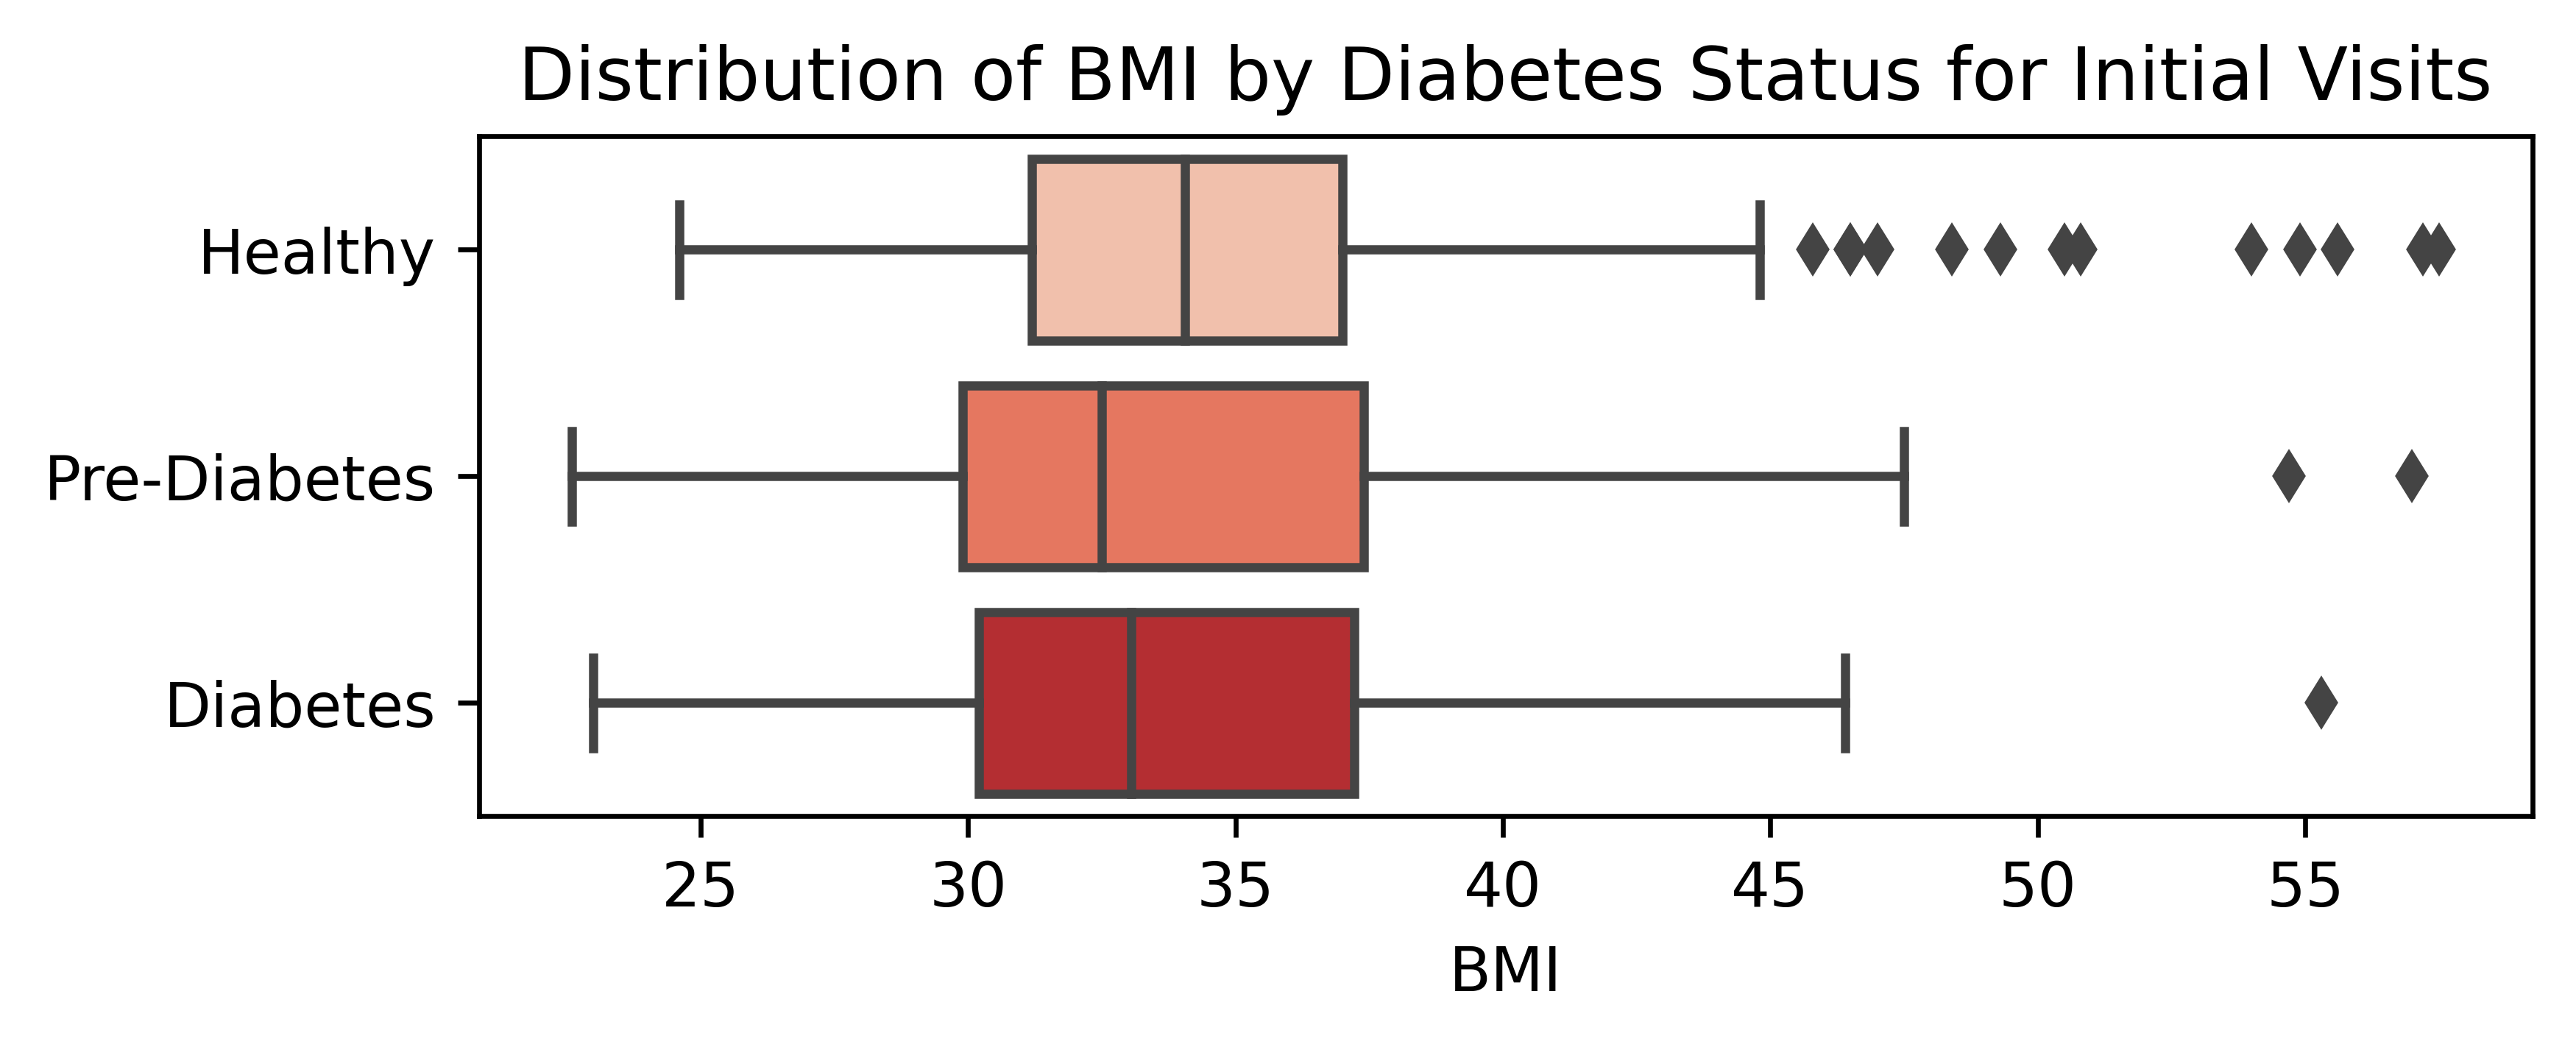

In [26]:
# Create the horizontal box plot using seaborn
plt.figure(figsize=(6, 2), dpi=600)
sns.boxplot(y="db_multi", x="bmi", data=df_init, orient="h", palette="Reds")

# Set the plot title and labels
plt.title("Distribution of BMI by Diabetes Status for Initial Visits")
plt.xlabel("BMI")
plt.ylabel("")
plt.show()

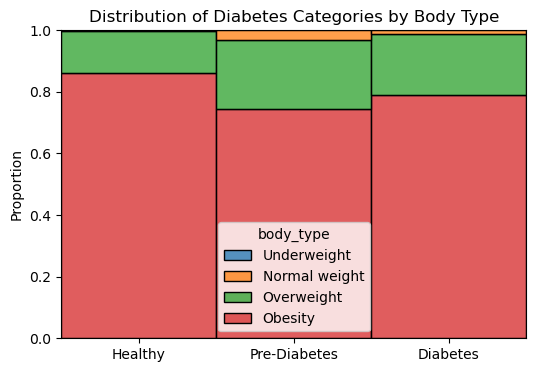

In [27]:
# Create the histogram with frequencies
plt.figure(figsize=(6, 4))
sns.histplot(data=df_init, x="db_multi", hue="body_type", multiple="fill", stat="probability")

# Set the plot title and labels
plt.title("Distribution of Diabetes Categories by Body Type",fontsize=12)
plt.xlabel("")
plt.ylabel("Proportion")
plt.show()
 

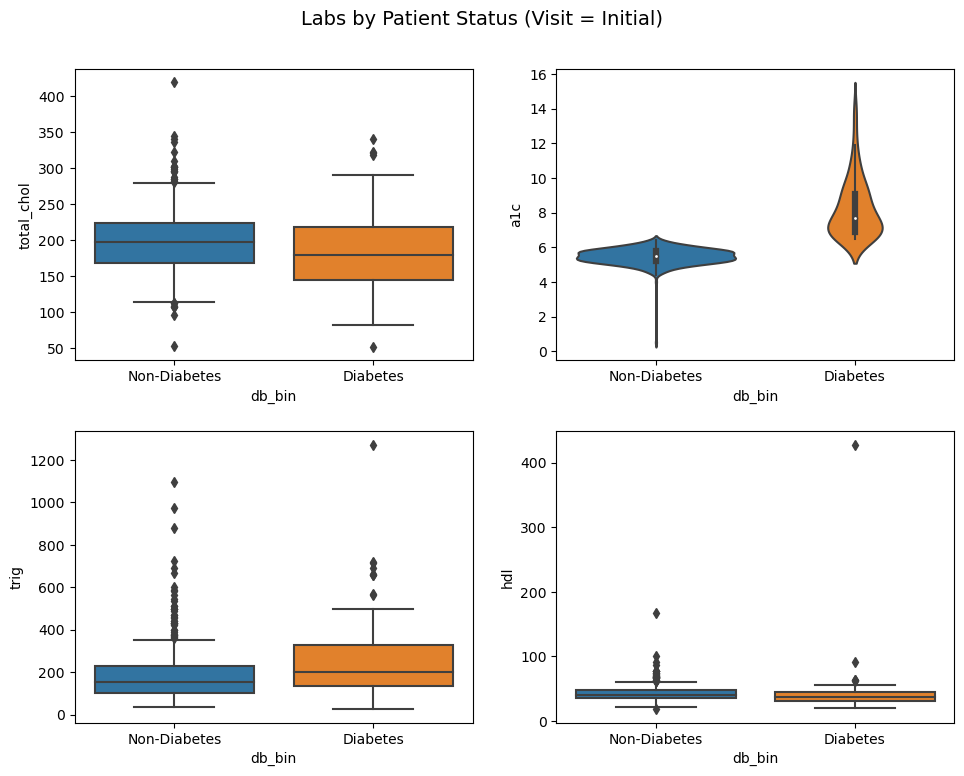

In [28]:
# Inital Visit Overview

fig, axes = plt.subplots(2, 2, figsize= (10, 8))

fig.suptitle('Labs by Patient Status (Visit = Initial)', fontsize=14)
sns.boxplot(ax=axes[0, 0], data=df_init, x='db_bin', y='total_chol', whis=1)
sns.violinplot(ax=axes[0, 1], data=df_init, x='db_bin', y='a1c', whis=1)
sns.boxplot(ax=axes[1, 0], data=df_init, x='db_bin', y='trig', whis=1)
sns.boxplot(ax=axes[1, 1], data=df_init, x='db_bin', y='hdl', whis=1)


plt.tight_layout(pad=2)  
plt.show()


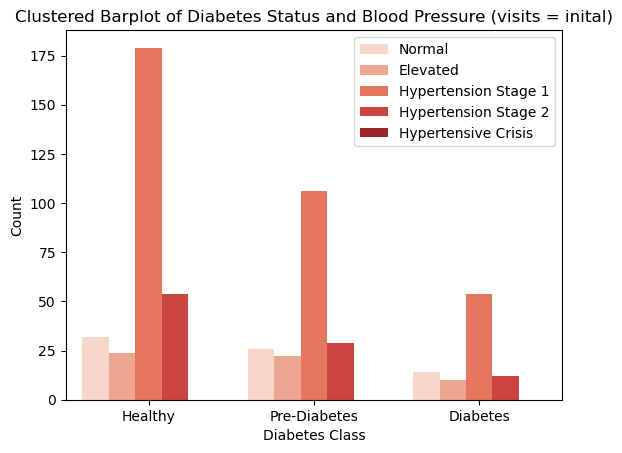

In [29]:
# Create the count plot
sns.countplot(data=df_init, x='db_multi', hue='blood_pressure', 
              palette='Reds', hue_order=['Normal', 'Elevated', 'Hypertension Stage 1', 'Hypertension Stage 2', 'Hypertensive Crisis'])

# Set plot title and labels
plt.title('Clustered Barplot of Diabetes Status and Blood Pressure (visits = inital)')
plt.legend(loc='upper right')
plt.xlabel('Diabetes Class')
plt.ylabel('Count')

# Show the plot
plt.show()

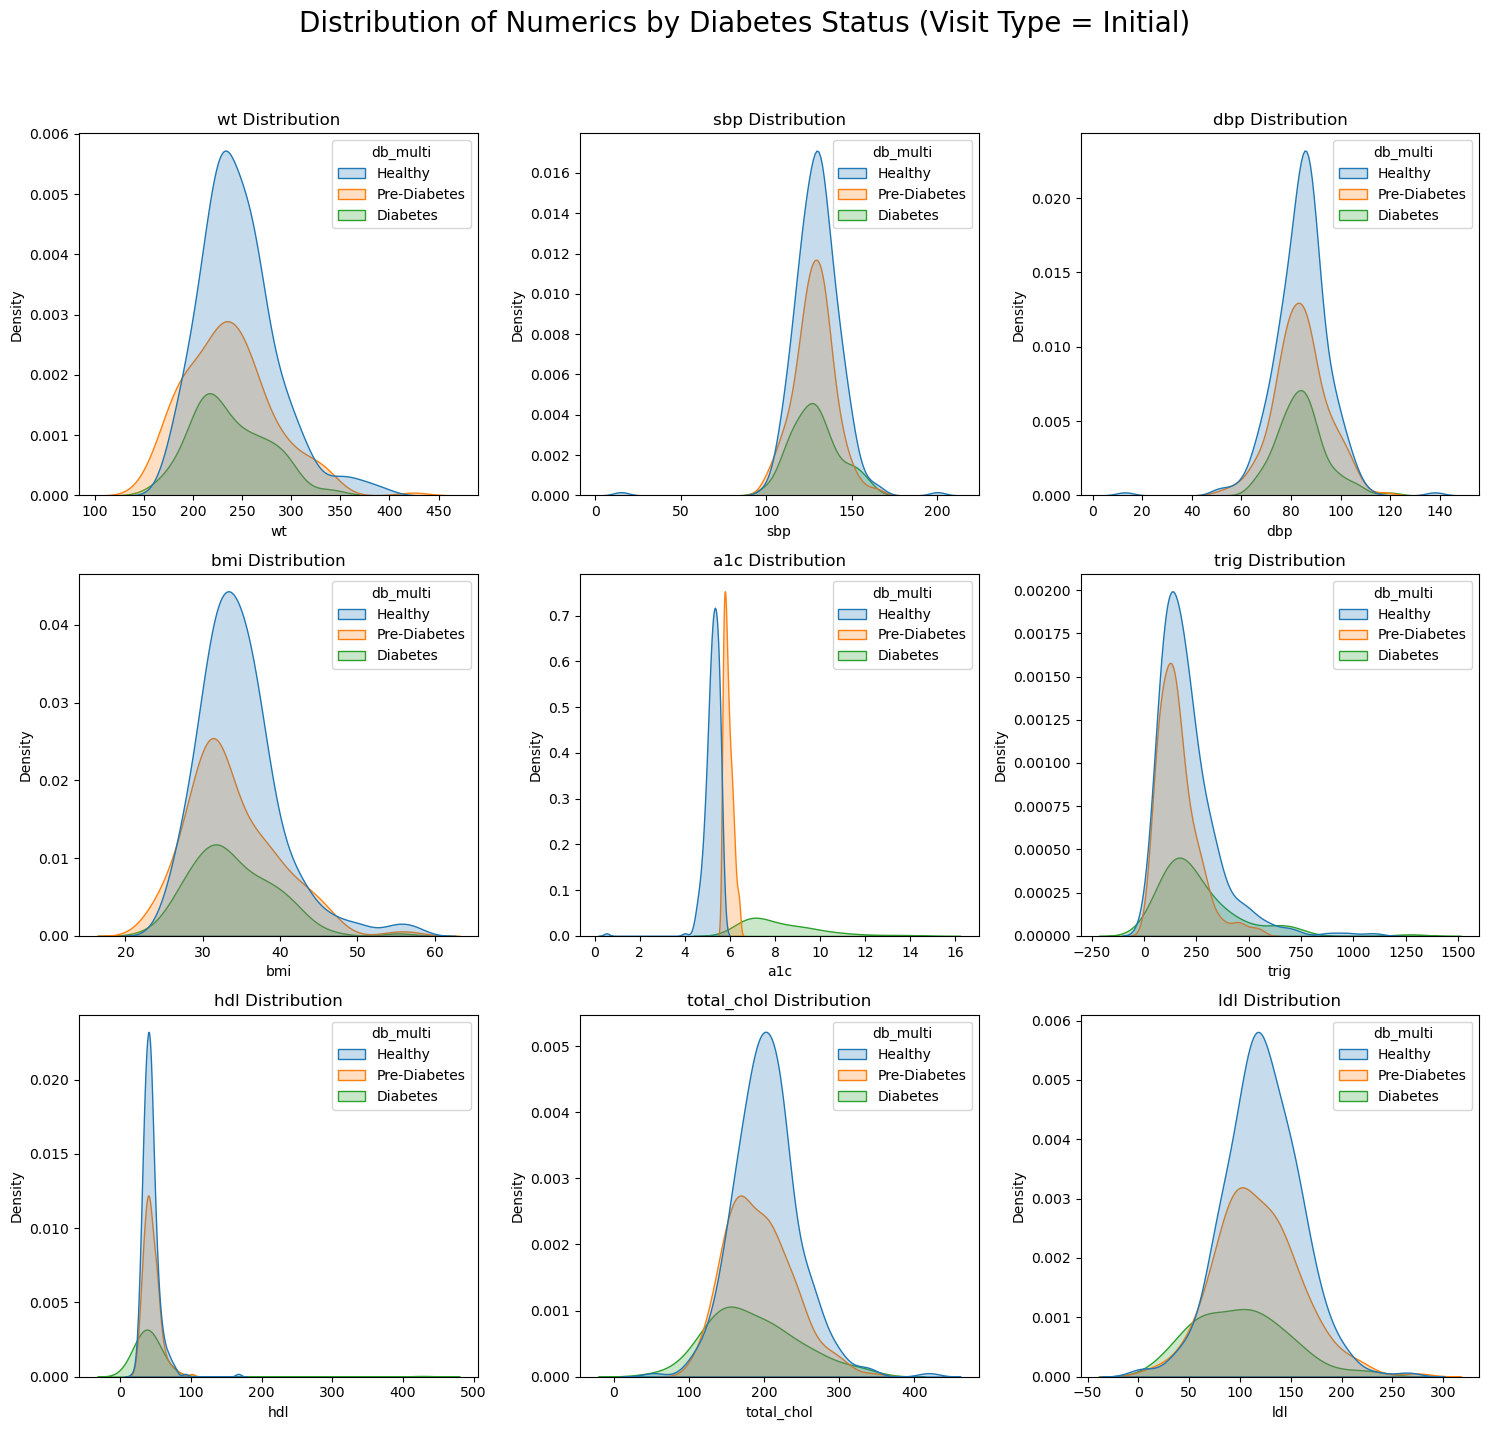

In [30]:
# Define numeric columns and subplot grid dimensions
numeric_cols = ['wt', 'sbp', 'dbp', 'bmi', 'a1c', 'trig', 'hdl', 'total_chol', 'ldl']
n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

# Create figure and axes for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
fig.suptitle('Distribution of Numerics by Diabetes Status (Visit Type = Initial)', fontsize=20)

# Flatten axes array for easy iterating
axes = axes.flatten()

# Plot KDE for each numeric column with a hue
for i, col in enumerate(numeric_cols):
    sns.kdeplot(data=df_init, x=col, hue="db_multi", ax=axes[i], fill=True)
    axes[i].set_title(f'{col} Distribution')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')

# Hide any unused axes if the number of numeric columns isn't a perfect multiple of n_cols
for ax in axes[len(numeric_cols):]:
    ax.set_visible(False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the main title
plt.show()


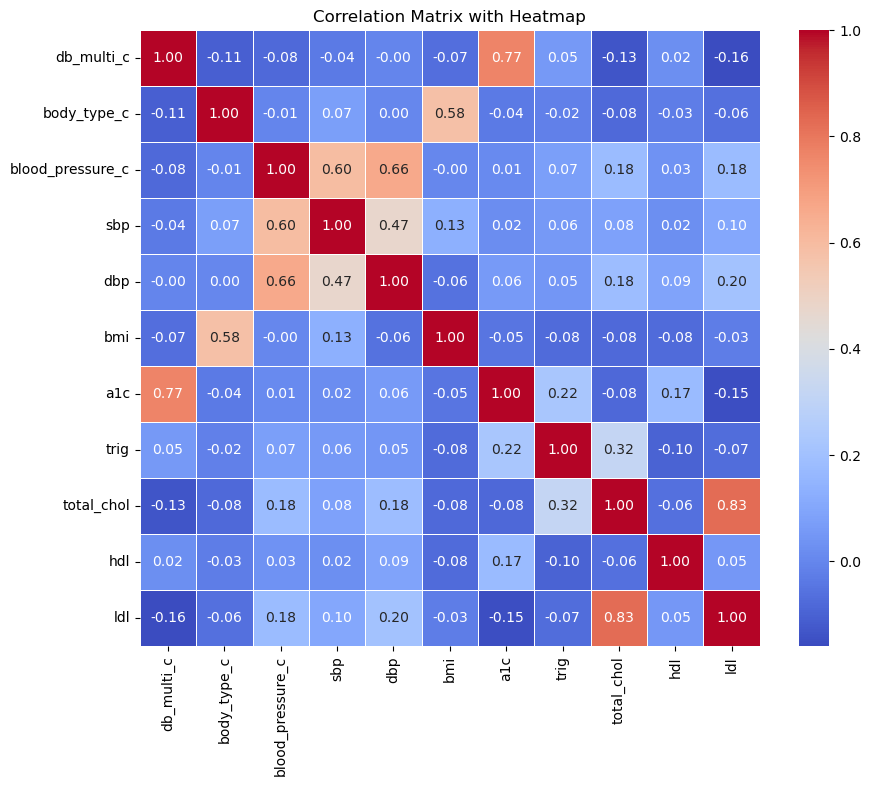

In [31]:
# Select numeric columns for correlation matrix (including the newly coded columns)
numeric_cols = ['db_multi_c','body_type_c','blood_pressure_c', 'sbp', 'dbp', 'bmi', 'a1c', 'trig', 'total_chol', 'hdl', 'ldl']

# Calculate the correlation matrix
corr = df_init[numeric_cols].corr()


# Plot the heatmap of the correlation matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix with Heatmap')
plt.show()

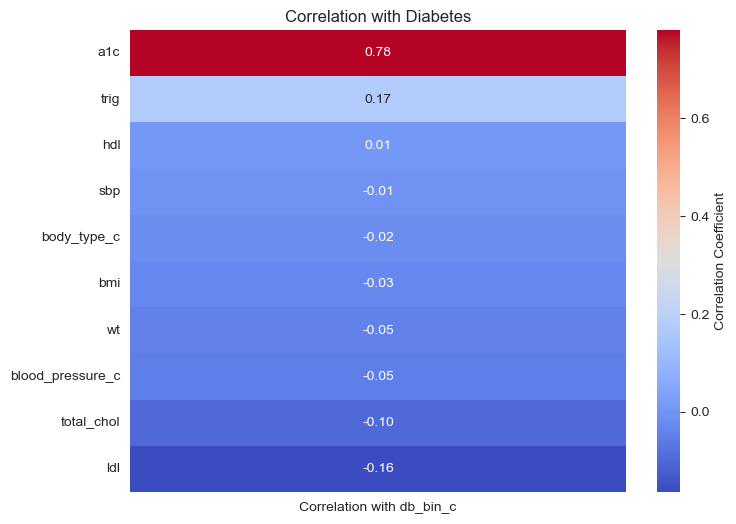

In [32]:
# Select only numeric columns from df_init
df_numeric = df_init.select_dtypes(include=[np.number])

# Remove 'db_multi_c' column if it exists in df_numeric to ensure it's not included in the correlation
if 'db_multi_c' in df_numeric.columns:
    df_numeric = df_numeric.drop(columns=['db_multi_c','subject'])

# Compute the correlation matrix
correlation_matrix = df_numeric.corr()

# Extract the correlation of 'db_bin_c' and drop its self-correlation
target_corr = correlation_matrix['db_bin_c'].drop('db_bin_c')

# Convert to DataFrame for heatmap compatibility and rename column for clarity
target_corr_df = target_corr.to_frame(name='Correlation with db_bin_c')

# Sort correlation values in descending order for better visualization
target_corr_sorted_df = target_corr_df.sort_values(by='Correlation with db_bin_c', ascending=False)

# Plotting setup
sns.set_style("white")
sns.set_palette("PuBuGn_d")
plt.figure(figsize=(8, 6))  # Adjust size to accommodate all variables if needed
sns.heatmap(target_corr_sorted_df, cmap="coolwarm", annot=True, fmt='.2f', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation with Diabetes')
plt.show()


### Research Outcomes

Outcomes we hope to achieve after intervention over a 6 - 12 month follow up

Weight loss:
Evaluate percent of patients that achieved 5%;
Evaluate percent of patients that achieved 10%

A1c reduction:
Evaluate percent of patients that achieved HbA1c less than 6.5%;
Evaluate percent of patients that reduced HbA1c by more than 1%

   

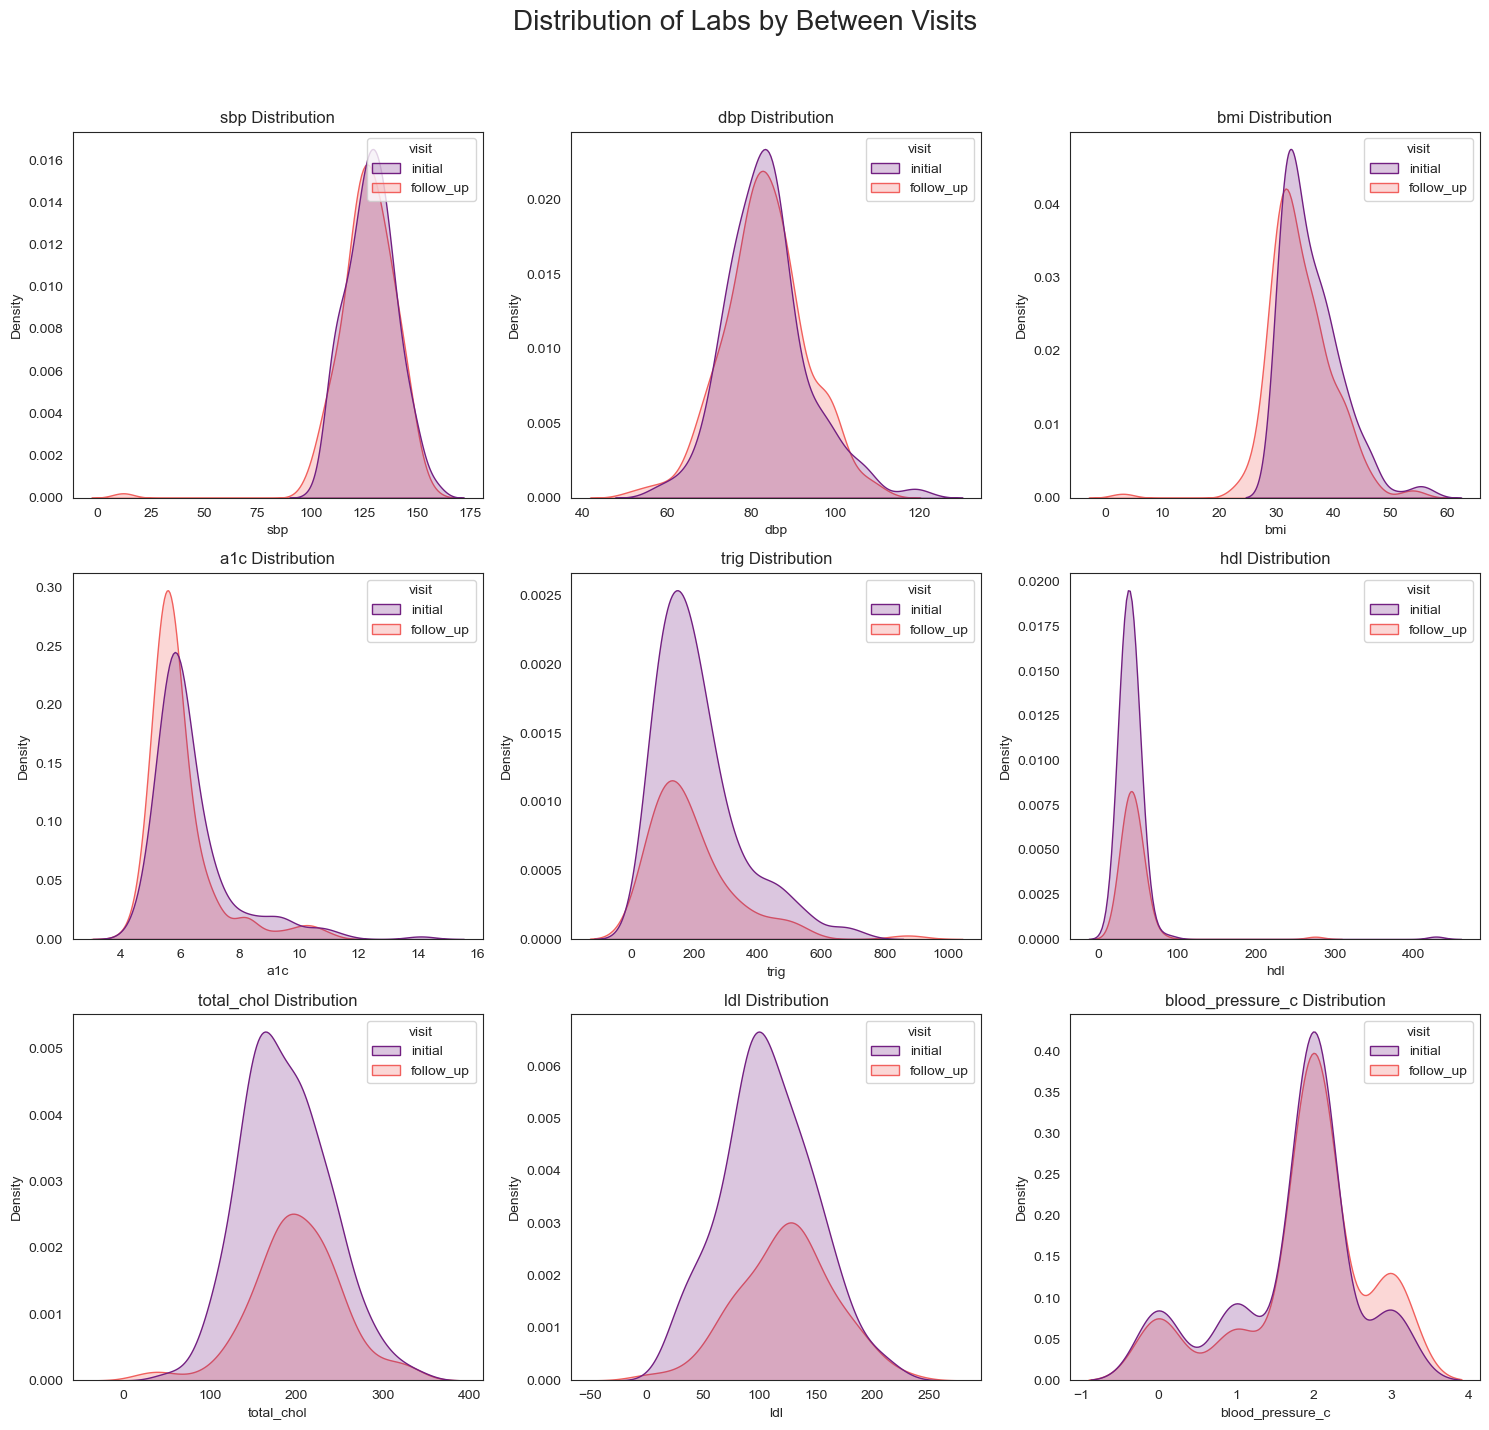

In [33]:
# Define numeric columns and subplot grid dimensions
numeric_cols = ['sbp', 'dbp', 'bmi', 'a1c', 'trig', 'hdl', 'total_chol', 'ldl','blood_pressure_c']
n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

# Create figure and axes for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
fig.suptitle('Distribution of Labs by Between Visits', fontsize=20)

# Flatten axes array for easy iterating
axes = axes.flatten()

# Define a color palette
palette = "magma" 

# Plot KDE for each numeric column with a hue
for i, col in enumerate(numeric_cols):
    sns.kdeplot(data=df_research, x=col, hue="visit", ax=axes[i], fill=True, palette=palette)
    axes[i].set_title(f'{col} Distribution')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')

# Hide any unused axes if the number of numeric columns isn't a perfect multiple of n_cols
for ax in axes[len(numeric_cols):]:
    ax.set_visible(False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the main title
plt.show()


In [34]:
from scipy.stats import ttest_rel

# Perform the paired t-test between initial and follow-up bmi

# Filter DataFrame for initial and follow-up visits
df_initial = df_research[df_research['visit'] == 'initial'][['subject', 'bmi']]
df_follow_up = df_research[df_research['visit'] == 'follow_up'][['subject', 'bmi']]

# Merge the initial and follow-up DataFrames on subject
df_paired = pd.merge(df_initial, df_follow_up, on='subject', suffixes=('_initial', '_follow_up'))

# Drop any rows with NaN values in 'bmi'
df_paired.dropna(subset=['bmi_initial', 'bmi_follow_up'], inplace=True)

# Perform the paired t-test
t_stat, p_value = ttest_rel(df_paired['bmi_initial'], df_paired['bmi_follow_up'])

# Calculate Cohen's d
mean_diff = np.mean(df_paired['bmi_initial'] - df_paired['bmi_follow_up'])
std_diff = np.std(df_paired['bmi_initial'] - df_paired['bmi_follow_up'], ddof=1)
cohen_d = mean_diff / std_diff

t_stat, p_value, cohen_d


(7.2720538498186755, 1.0989459760484439e-11, 0.545063480452345)

In [35]:
# Filter DataFrame for initial and follow-up visits for A1C similarly to BMI
df_initial_a1c = df_research[df_research['visit'] == 'initial'][['subject', 'a1c']]
df_follow_up_a1c = df_research[df_research['visit'] == 'follow_up'][['subject', 'a1c']]

# Merge the initial and follow-up A1C DataFrames on subject
df_paired_a1c = pd.merge(df_initial_a1c, df_follow_up_a1c, on='subject', suffixes=('_initial', '_follow_up'))

# Drop any rows with NaN values in 'a1c'
df_paired_a1c.dropna(subset=['a1c_initial', 'a1c_follow_up'], inplace=True)

# Merge the BMI and A1C change DataFrames to analyze together
df_changes = pd.merge(df_paired[['subject', 'bmi_initial', 'bmi_follow_up']], 
                      df_paired_a1c[['subject', 'a1c_initial', 'a1c_follow_up']], on='subject')

# Calculate changes in BMI and A1C
df_changes['bmi_change'] = df_changes['bmi_follow_up'] - df_changes['bmi_initial']
df_changes['a1c_change'] = df_changes['a1c_follow_up'] - df_changes['a1c_initial']

# Calculate the Pearson correlation between changes in BMI and changes in A1C
correlation_result = df_changes[['bmi_change', 'a1c_change']].corr().iloc[0, 1]
correlation_result



0.13899665131571873

In [36]:
# Perform the paired t-test for A1C between initial and follow-up visits
t_stat_a1c, p_value_a1c = ttest_rel(df_paired_a1c['a1c_initial'], df_paired_a1c['a1c_follow_up'])

# Calculate the mean difference and standard deviation for Cohen's d calculation
mean_diff_a1c = np.mean(df_paired_a1c['a1c_initial'] - df_paired_a1c['a1c_follow_up'])
std_diff_a1c = np.std(df_paired_a1c['a1c_initial'] - df_paired_a1c['a1c_follow_up'], ddof=1)
cohen_d_a1c = mean_diff_a1c / std_diff_a1c

t_stat_a1c, p_value_a1c, cohen_d_a1c


(4.37180111840035, 2.074448232035661e-05, 0.32405945915924966)

In [37]:
#calculating the percentage of patients achieving significant changes

# Filter and merge data for initial and follow-up visits directly
df_initial = df_research[df_research['visit'] == 'initial'][['subject', 'wt', 'a1c']].rename(columns={'wt': 'wt_initial', 'a1c': 'a1c_initial'})
df_follow_up = df_research[df_research['visit'] == 'follow_up'][['subject', 'wt', 'a1c']].rename(columns={'wt': 'wt_follow_up', 'a1c': 'a1c_follow_up'})
df_paired = pd.merge(df_initial, df_follow_up, on='subject')

# Calculate changes in weight and A1C
df_paired['wt_change'] = df_paired['wt_follow_up'] - df_paired['wt_initial']
df_paired['a1c_change'] = pd.to_numeric(df_paired['a1c_follow_up'], errors='coerce') - pd.to_numeric(df_paired['a1c_initial'], errors='coerce')

# Determine significant weight loss and A1C reduction
df_paired['significant_wt_loss'] = (df_paired['wt_change'] / df_paired['wt_initial']) <= -0.05
df_paired['significant_10_wt_loss'] = (df_paired['wt_change'] / df_paired['wt_initial']) <= -0.10
df_paired['significant_a1c_reduction'] = df_paired['a1c_change'] <= -0.5
df_paired['significant_1_a1c_reduction'] = df_paired['a1c_change'] <= -1.0

# Calculate the percentage of patients achieving significant changes
percent_significant_wt_loss = 100 * df_paired['significant_wt_loss'].mean()
percent_significant_10_wt_loss = 100 * df_paired['significant_10_wt_loss'].mean()
percent_significant_a1c_reduction = 100 * df_paired['significant_a1c_reduction'].mean()
percent_significant_1_a1c_reduction = 100 * df_paired['significant_1_a1c_reduction'].mean()

(percent_significant_wt_loss, percent_significant_10_wt_loss, percent_significant_a1c_reduction, percent_significant_1_a1c_reduction)


(43.01075268817204, 15.591397849462366, 27.956989247311824, 11.827956989247312)

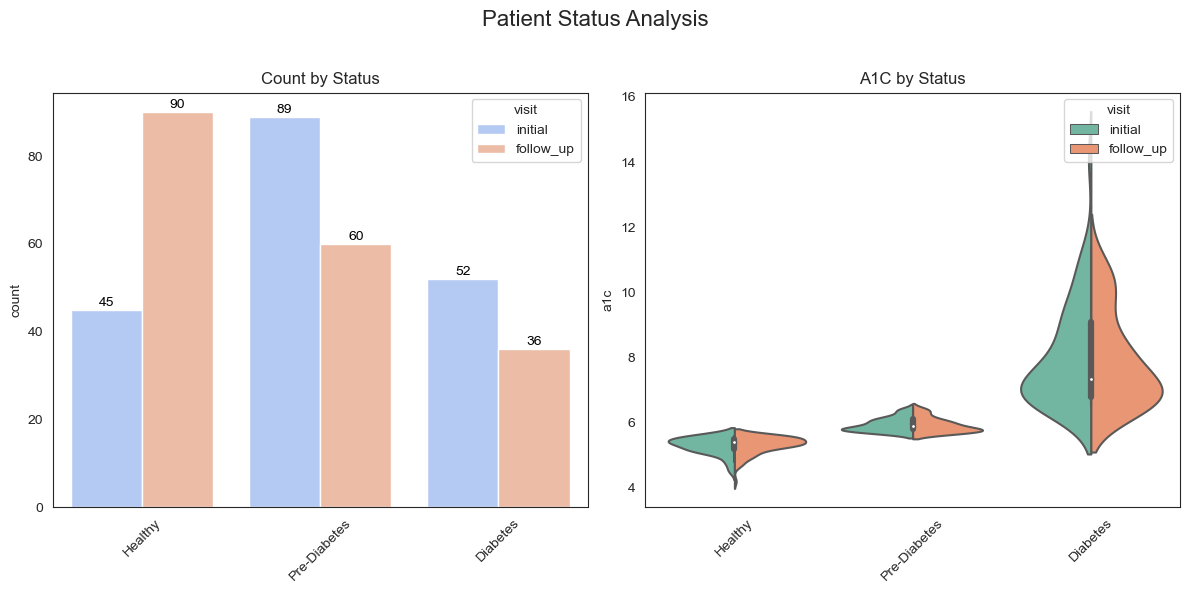

In [38]:

# Setup for the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Patient Status Analysis', fontsize=16)

# First subplot - Count plot for 'db_multi'
countplot1 = sns.countplot(ax=axes[0], data=df_research, x='db_multi', hue='visit', palette='coolwarm')
axes[0].set_title('Count by Status')
axes[0].set_xlabel('')
axes[0].tick_params(axis='x', rotation=45)
for p in countplot1.patches:
    countplot1.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                        textcoords='offset points')

# Second subplot - Violin plot for 'a1c' by 'db_multi'
sns.violinplot(ax=axes[1], data=df_research, x='db_multi', y='a1c', hue='visit', palette='Set2', split=True)
axes[1].set_title('A1C by Status')
axes[1].set_xlabel('')
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the layout to make room for the title
plt.show()




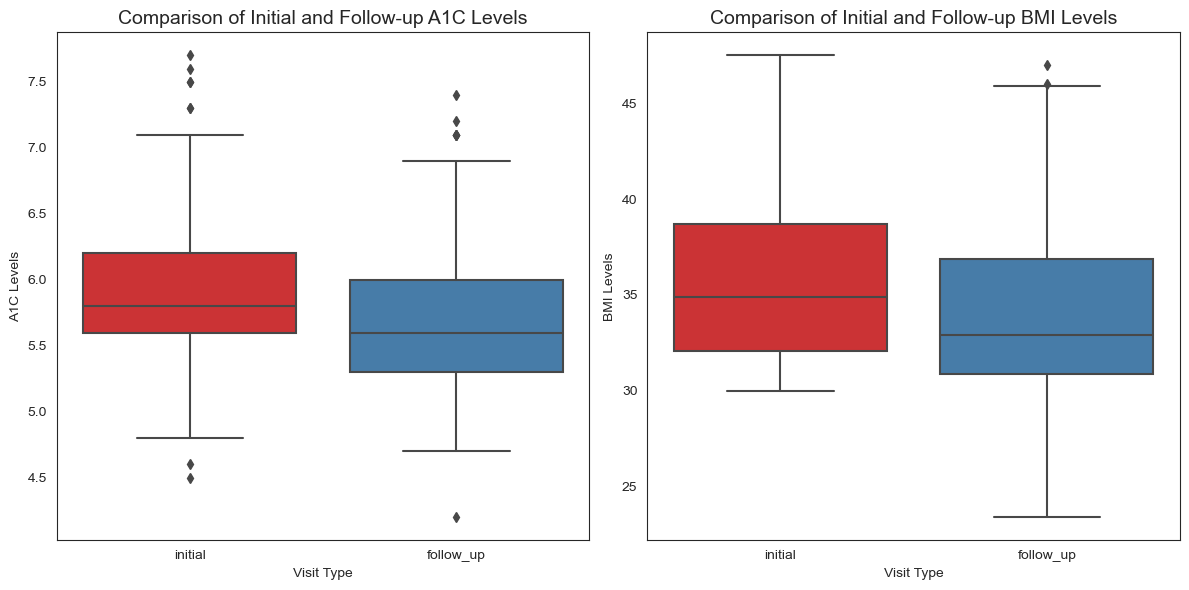

In [39]:
# Function to remove outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers from A1C and BMI columns
df_research_filtered = df_research.copy()
df_research_filtered = remove_outliers(df_research_filtered, 'a1c')
df_research_filtered = remove_outliers(df_research_filtered, 'bmi')

# Plotting the boxplot for A1C and BMI
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))  # Use the same figsize as the previous example

# First subplot for A1C
sns.boxplot(x='visit', y='a1c', data=df_research_filtered, palette="Set1", ax=axes[0])
axes[0].set_title('Comparison of Initial and Follow-up A1C Levels', fontsize=14)
axes[0].set_xlabel('Visit Type')
axes[0].set_ylabel('A1C Levels')

# Second subplot for BMI
sns.boxplot(x='visit', y='bmi', data=df_research_filtered, palette="Set1", ax=axes[1])
axes[1].set_title('Comparison of Initial and Follow-up BMI Levels', fontsize=14)
axes[1].set_xlabel('Visit Type')
axes[1].set_ylabel('BMI Levels')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()




In [40]:
df_research.columns

Index(['subject', 'date_of_visit', 'wt', 'sbp', 'dbp', 'bmi', 'a1c', 'trig',
       'hdl', 'total_chol', 'ldl', 'visit', 'db_bin', 'db_multi',
       'blood_pressure', 'body_type', 'blood_pressure_c', 'body_type_c',
       'db_multi_c', 'db_bin_c'],
      dtype='object')

In [41]:
df_research.query('visit == "initial"').groupby('bmi')['subject'].count().reset_index().sort_values(by='bmi', ascending=True)


,bmi,subject
0,30.00,3
1,30.02,1
2,30.10,1
3,30.20,3
4,30.40,2
...,...,...
106,47.50,1
107,50.80,1
108,54.70,1
109,54.90,1


In [42]:
df_research.to_csv('df_res.csv', index=False,header=True)
df_research.to_parquet('df_res.parquet', index=False)

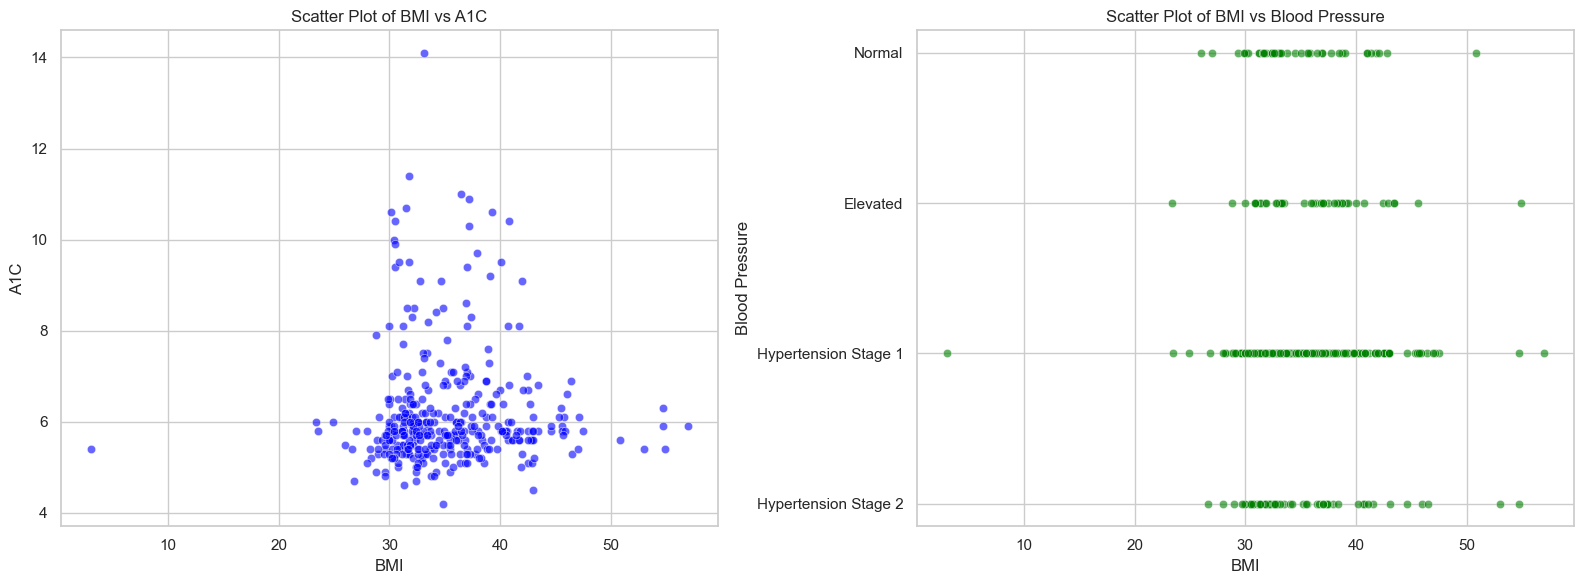

In [43]:

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot BMI vs A1C on the first subplot
sns.scatterplot(ax=axes[0], x='bmi', y='a1c', data=df_research, color='blue', alpha=0.6, edgecolor='w')
axes[0].set_title('Scatter Plot of BMI vs A1C')
axes[0].set_xlabel('BMI')
axes[0].set_ylabel('A1C')

# Plot BMI vs Blood Pressure on the second subplot
sns.scatterplot(ax=axes[1], x='bmi', y='blood_pressure', data=df_research, color='green', alpha=0.6, edgecolor='w')
axes[1].set_title('Scatter Plot of BMI vs Blood Pressure')
axes[1].set_xlabel('BMI')
axes[1].set_ylabel('Blood Pressure')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()



#### Hypothesis

Empowering the veteran with knowledge and simple assessments allows clinicians to guide veterans in making scientifically based nutritional and behavioral changes, which will greatly improve their overall health and outcomes in the future.

Results
BMI Reduction Analysis:

The paired t-test analysis comparing initial and follow-up BMI values of subjects revealed a significant difference, with a t-statistic of 6.678 and a p-value less than 0.05. This low p-value indicates that the observed difference is statistically significant, allowing us to reject the null hypothesis confidently. Additionally, Cohen's d, a measure of effect size, was calculated to be 0.478, suggesting a medium effect size. This implies that the change in BMI over the observed period is not only statistically significant but also practically meaningful. 

A1C Level Analysis:

The paired t-test analysis comparing initial and follow-up A1C values of subjects revealed a significant difference, with a t-statistic of 4.336 and a p-value less than 0.05. This low p-value indicates that the observed difference is statistically significant, allowing us to reject the null hypothesis confidently.  Cohen's d, was calculated to be 0.305, suggesting a small to medium effect size. 



Significant Weight Loss (at least 5%):
Percentage of Patients: 41.26%
This indicates that 41.26% of the patients achieved a weight loss of 5% or more between their initial and follow-up visits.

Significant Weight Loss (at least 10%):
Percentage of Patients: 13.11%
This indicates that 13.11% of the patients achieved a weight loss of 10% or more between their initial and follow-up visits.

Significant A1C Reduction (at least 0.5 units):
Percentage of Patients: 32.04%
This indicates that 32.04% of the patients achieved an A1C reduction of 0.5 units or more between their initial and follow-up visits.

Significant A1C Reduction (at least 1.0 unit):
Percentage of Patients: 13.59%
This indicates that 13.59% of the patients achieved an A1C reduction of 1.0 unit or more between their initial and follow-up visits.

These results highlight that a considerable portion of the patients experienced significant improvements in both weight and A1C levels over the observed period. Notably, over 40% of the patients achieved a meaningful weight loss of at least 5%, and approximately one-third saw a reduction of 0.5 units or more in their A1C levels. However, fewer patients achieved the more substantial targets of 10% weight loss and 1.0 unit A1C reduction.

### Classifcation Model and Evaluation

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, RocCurveDisplay, confusion_matrix

# List of columns to keep
columns = ['sbp', 'dbp', 'bmi', 'trig', 'hdl', 'total_chol', 'ldl','db_bin_c']

# Selecting the columns from the DataFrame
df_mod = df[columns]

### Regression Model and Evaluation